<h1 align="center"> Chapter 5: Exploiting Generative Adversarial Networks for credit card fraud detection on simulated transactions </h1>


<h2> Our Goals </h2>
The purpose of this section is to deal with one of the most challenging problem of credit card fraud detection: the imbalance class problem. To do so we will employ two different methods: SMOTE and GAN oversampling. The former is a very popular method in literature that has already been used in many publications. The latter represents the focus of our thesis, and we will analyze it deeply to understand whether we can obtain acceptable results. The  train and test datasets have been created through a transactions simulator in a previous section. 
<h2> Index: </h2>

5.1 <b>Data overview and preparation (PART II) </b><br>
5.1.1 [Data Loading and Overview](#da) <br>
5.1.2 [Scaling](#da) <br>
5.1.3 [Train-test split](#da) <br>

5.2 <b>GAN OVERSAMPLING </b><br>
5.2.1 [GAN Creation](#da) <br>
5.2.2 [Analysis of the created dataset](#da) <br>
5.2.3 [Classification with GAN](#da) <br>
5.2.4 [Performance and Testing](#da) <br><br>

5.3 <b>SMOTE Oversampling</b><br>
5.3.1 [Classifiers ](#classifiers)<br>
5.3.2 [Performance and Testing](#logistic)<br><br> 

5.4 <b> Model comparison </b><br>

5.4.1 [Performance measures and matrices ](#logistic)<br><br>


# **5.1 DATA overview and preparation**

## 5.1.1 Data Loading and overview

As usual our first step  is to download our previously created functions and our datasets

In [1]:
#mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load shared functions
!curl -O https://raw.githubusercontent.com/leonardoimperit/thesis-timperi/main/shared_functions_imports.py
%run shared_functions_imports.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4862  100  4862    0     0  30198      0 --:--:-- --:--:-- --:--:-- 30198


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

As usual, we first have to load our dataset: in this case the previously created synthetic transactions

In [3]:
DIR_INPUT='/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/train&test minmax scaled/train/' 

BEGIN_DATE = "2021-05-06"
END_DATE = "2021-07-20"

print("Load  files")
%time train_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(train_df),train_df.TX_FRAUD.sum()))


Load  files
CPU times: user 573 ms, sys: 463 ms, total: 1.04 s
Wall time: 21.7 s
728537 transactions loaded, containing 6405 fraudulent transactions


In [4]:
DIR_INPUT='/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/train&test minmax scaled/test/' 

BEGIN_DATE = "2021-07-28"
END_DATE = "2021-09-09"

print("Load  files")
%time test_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(test_df),test_df.TX_FRAUD.sum()))


Load  files
CPU times: user 246 ms, sys: 47.8 ms, total: 294 ms
Wall time: 9.2 s
158744 transactions loaded, containing 951 fraudulent transactions


We check the proportion of frauds and no frauds

In [5]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(train_df['TX_FRAUD'].value_counts()[0]/len(train_df) * 100,2), '% of the train dataset')
print('Frauds', round(train_df['TX_FRAUD'].value_counts()[1]/len(train_df) * 100,2), '% of the train dataset')

print('No Frauds', round(test_df['TX_FRAUD'].value_counts()[0]/len(test_df) * 100,2), '% of the test dataset')
print('Frauds', round(test_df['TX_FRAUD'].value_counts()[1]/len(test_df) * 100,2), '% of the test dataset')

No Frauds 99.12 % of the train dataset
Frauds 0.88 % of the train dataset
No Frauds 99.4 % of the test dataset
Frauds 0.6 % of the test dataset


In [6]:
output_feature="TX_FRAUD"

input_features = ['LOG_TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'LOG_CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'LOG_CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'LOG_CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']
nonbinary_input_features=['LOG_TX_AMOUNT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'LOG_CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'LOG_CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'LOG_CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW'] 


## 5.1.3 Train and Test Splitting

In [7]:
original_Xtrain = train_df[input_features].values
original_Xtest = test_df[input_features].values
original_ytrain = train_df[output_feature].values
original_ytest = test_df[output_feature].values
original_Xtrain_nofraudindex = original_ytrain ==0
original_Xtrain_fraudindex = original_ytrain ==1
original_Xtest_nofraudindex = original_ytest ==0
original_Xtest_fraudindex = original_ytest ==1

In [8]:
original_Xtrain_df = pd.DataFrame(original_Xtrain)
original_Xtrain_df.columns = train_df[input_features].columns
original_Xtest_df = pd.DataFrame(original_Xtest)
original_Xtest_df.columns = test_df[input_features].columns
original_Xtrain_df_fraud = original_Xtrain_df.iloc[original_Xtrain_fraudindex]
original_Xtrain_df_nofraud = original_Xtrain_df.iloc[original_Xtrain_nofraudindex]
original_Xtest_df_fraud = original_Xtest_df.iloc[original_Xtest_fraudindex]
original_Xtest_df_nofraud = original_Xtest_df.iloc[original_Xtest_nofraudindex]

The proportion of frauds is similar on the test and train set. This means that we performed our splitting correctly

# **5.2 GAN OVERSAMPLING**
We arrive here to the center of our analysis. In the first section we will try to create and train a Generative Adversarial Network. In the second section we will employ as an oversampling method with the aim to solve our imbalance classification problem


## 5.2.1 Creation of a Generative Adversarial Network

We start by importing the required packages. We will use tensorflow keras developed by google, which runs the google colab platform

In [9]:
import tensorflow as tf
from random import randint
import sys

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
# example of loading the mnist dataset

Our first step is the creation of a Discriminator class. The network here is just a preliminary one with default loss and activation functions and just 3 layers.

In [45]:
class Discriminator(object):
       def __init__(self, number_features = 15,
                    latent_size=100):
           # Initialize Variables
            np.random.seed(0)
            self.CAPACITY = number_features
            self.SHAPE = (number_features,)
            self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
            self.Discriminator = self.model()
            self.Discriminator.compile(loss='binary_crossentropy',
                               optimizer=self.OPTIMIZER, metrics=['accuracy'] )
            self.Discriminator.summary()
       def model(self):
           # Build the binary classifier and return it
            model = Sequential()
            model.add(Flatten(input_shape=self.SHAPE))
            model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(Dense(int(self.CAPACITY/2)))
            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
            model.add(Dense(1, activation='sigmoid'))
            return model
       def summary(self):
            return self.Discriminator.summary()
           # Prints the Model Summary to the Screen

The same is true here for our generator. It is a simple neural network with the number of layers as parameters. Here 4 is set as the default. Loss functions and optimnizers are still default ones.

In [44]:
class Generator(object):
       def __init__(self, number_features = 15,
                    latent_size=100, num_blocks = 4):
            # Initialize Variables
           np.random.seed(0)
           self.number_features = number_features 
           self.num_blocks = num_blocks
           self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
           self.LATENT_SPACE_SIZE = latent_size
           self.latent_space = np.random.normal(0,1,
                                           (self.LATENT_SPACE_SIZE,))
           self.Generator = self.model()
           self.Generator.compile(loss='binary_crossentropy',
                                  optimizer=self.OPTIMIZER)
           self.Generator.summary()
            
       def model(self, block_starting_size=60):
           model = Sequential()
           block_size = block_starting_size
           model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
           model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
           model.add(BatchNormalization(momentum=0.8))
           for i in range(self.num_blocks-1):
                            block_size = block_size 
                            model.add(Dense(block_size))
                            model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
                            model.add(BatchNormalization(momentum=0.8))
           model.add(Dense(self.number_features , activation='sigmoid'))
           model.add(Reshape((self.number_features, )))
           return model
           # Build the generator model and returns it
       def summary(self):
           return self.Generator.summary()
           # Prints the Model Summary to the screen
       #def save_model(self):
           # Saves the model structure to a file in the data folder

Finally our GAN network is created! It is defined as just the sum of the Discriminator and the Generator networks. 

In [46]:
class GAN(object):
       def __init__(self, discriminator,generator):
           self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
           self.Generator = generator
           self.Discriminator = discriminator
           self.Discriminator.trainable = False
           self.gan_model = self.model()
           self.gan_model.compile(loss='binary_crossentropy',
                                  optimizer=self.OPTIMIZER)
           self.gan_model.summary()

           # Initialize Variables
       def model(self):
           model = Sequential()
           model.add(self.Generator)
           model.add(self.Discriminator)
           return model

           # Build the adversarial model and return it
        
       def summary(self):
           return gan_model.summary()
           # Prints the Model Summary to the Screen

Here we have the Trainer Class. What is very important here is to define it in a way that the GAN can learn in an adversarial way. For each step we will have that when the generator learns the discriminator stop learning and viceversa. If we don't employ this simple strategy it will be impossible for the system to converge and provide acceptable results.

In [47]:
class Trainer:
         def __init__(self, X_trainer, number_features = 15,latent_size=100, iterations = 5000, batch=32, num_blocks = 4):
          self.X_train = np.array(X_trainer).copy()
          self.number_features = number_features 
          self.iterations = iterations
          self.BATCH = batch
          self.LATENT_SPACE_SIZE = latent_size
          self.generator = Generator(number_features=self.number_features, latent_size=self.LATENT_SPACE_SIZE, num_blocks = num_blocks )
          self.discriminator = Discriminator(number_features =self.number_features)
          self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)
          self.load_data()
         def sample_latent_space(self, instances):
                    return np.random.normal(0, 1,(instances,self.LATENT_SPACE_SIZE))
         def train(self):
                d_loss_list = np.array([])
                g_loss_list = np.array([])
                for e in range(self.iterations):
                  # Grab a batch
                    count_real_frauds = int(self.BATCH/2)
                    starting_index = randint(0, (len(self.X_train)-count_real_frauds))
                    real_frauds_raw = self.X_train[starting_index : (starting_index +count_real_frauds)]
                    x_real_frauds = real_frauds_raw.reshape( count_real_frauds, self.number_features)
                    y_real_labels = np.ones([count_real_frauds,1])
                    # Grab Generated Images for this training batch
                    latent_space_samples = self.sample_latent_space(count_real_frauds)
                    x_generated_frauds = self.generator.Generator.predict(latent_space_samples)
                    y_generated_labels = np.zeros([self.BATCH-count_real_frauds,1])
                    # Combine to train on the discriminator
                    x_batch = np.concatenate( [x_real_frauds, x_generated_frauds] )
                    y_batch = np.concatenate( [y_real_labels, y_generated_labels] )
                    # Now, train the discriminator with this batch
                    discriminator_loss  = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
                    d_loss_list = np.append(d_loss_list,discriminator_loss)
                    # Generate Noise
                    x_latent_space_samples = self.sample_latent_space(self.BATCH)
                    y_generated_labels = np.ones([self.BATCH,1])
                    generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
                    g_loss_list = np.append(g_loss_list,generator_loss)
                    print ('Iteration:' + str(int(e)) + ', [Discriminator :: Loss:' + str(discriminator_loss)+'], [ Generator :: Loss:'+str(generator_loss)+']')
                return d_loss_list, g_loss_list
         def load_data(self):
                      self.X_train = np.float32(self.X_train)
                      self.X_train = np.expand_dims(self.X_train, axis=2)
                      return

The parameters are set in such a way that maximize  our performance measures. This were obtaines with a reference to theory and after some trial-and-error. We are still in a preliminary phase.

In [48]:
#!/usr/bin/env python3
NUMBER_FEATURES  = 15
LATENT_SPACE_SIZE = 100
ITERATIONS = 2000
BATCH = 128
NUM_BLOCKS = 3
trainer = Trainer(X_trainer = original_Xtrain_df_fraud,number_features = NUMBER_FEATURES, latent_size=LATENT_SPACE_SIZE, iterations =ITERATIONS, batch=BATCH, num_blocks = NUM_BLOCKS)
d_loss, g_loss = trainer.train()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 60)                6060      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 60)                0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 60)                240       
_________________________________________________________________
dense_40 (Dense)             (None, 60)                3660      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 60)                0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 60)                240       
_________________________________________________________________
dense_41 (Dense)             (None, 60)              

This graph shows the behaviour of our generative and discriminative loss. We can see that there are some problems in the discriminator with relevant oscillation. However we can see that the scale of the difference is very small and overall the system does not diverge, despite the relatively significant variance through the epochs. Moreover we can see that the discriminative loss oscillate around 0.5, that is exactly the Nash Equilibrium that we expect for this type of networks.

Text(0, 0.5, 'Loss')

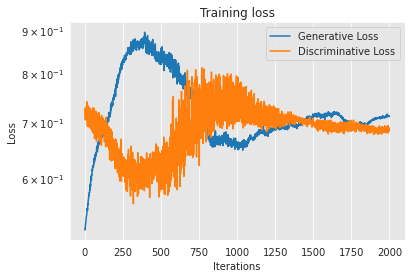

In [49]:
import pandas as pd
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")

## 5.2.2 Creation of the oversampled dataset employing the trained GAN

The sample_latent_space function is fundamental to create variation in the generated frauds

In [50]:
def sample_latent_space(instances, latent_space_size):
                    return np.random.normal(0, 1,(instances,latent_space_size))

In [51]:
original_Xtrain_df.shape[0] 

728537

In [52]:
#for a balanced dataset we need to generate nofraud_df.shape[0] - fraud_df.shape[0] new transactions
proportion = [0.02,0.05,0.1,0.2,0.3,0.4,0.5]
balanced_datasets_gan = {}
proper__number_new_frauds_old = 0 
new_frauds_cumulative = pd.DataFrame()
for alpha in proportion: 
        proper__number_new_frauds_new = int((original_Xtrain_df.shape[0]*alpha - original_Xtrain_df_fraud.shape[0])/(1-alpha))
        number_new_frauds = proper__number_new_frauds_new - proper__number_new_frauds_old
        print(number_new_frauds)
        latent_space_samples = sample_latent_space(number_new_frauds,LATENT_SPACE_SIZE)
        new_generated_frauds = trainer.generator.Generator.predict(latent_space_samples)
        new_generated_frauds = np.reshape(new_generated_frauds,(number_new_frauds,15))
        new_frauds_gan = pd.DataFrame(new_generated_frauds)
        new_frauds_gan.columns = train_df[input_features].columns
        new_frauds_gan['TX_FRAUD'] = 1
        new_frauds_cumulative = new_frauds_cumulative.append(new_frauds_gan)
        original_nofraud_dftrain_with_class = original_Xtrain_df_nofraud.copy()
        original_nofraud_dftrain_with_class['TX_FRAUD']=0
        original_fraud_dftrain_with_class = original_Xtrain_df_fraud.copy()
        original_fraud_dftrain_with_class['TX_FRAUD']=1
        new_balanced_dataset_gan = pd.concat([original_nofraud_dftrain_with_class, original_fraud_dftrain_with_class, new_frauds_cumulative], axis = 0 )
        df_name = 'new_balanced_dataset_gan'+ str(alpha)
        balanced_datasets_gan[df_name] = new_balanced_dataset_gan
        proper__number_new_frauds_old = proper__number_new_frauds_new

8332
23269
42230
100296
128953
171936
240711


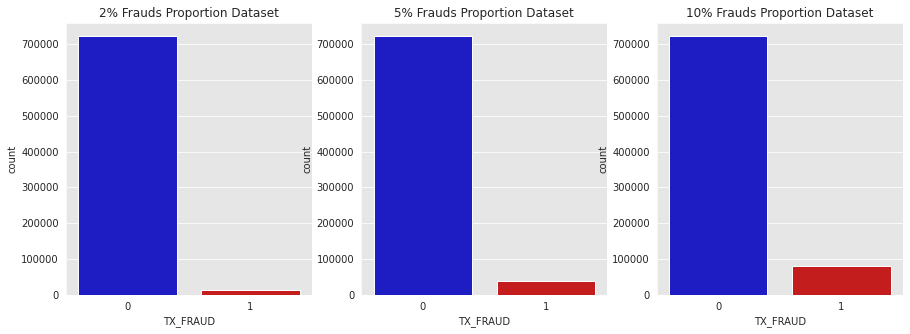

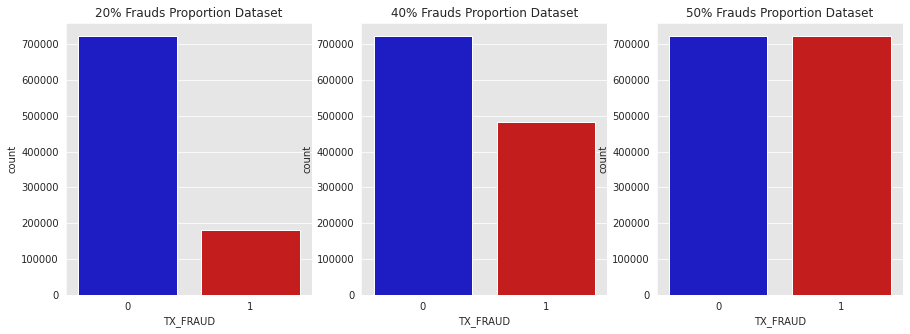

In [ ]:
colors = ["#0101DF", "#DF0101"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.countplot('TX_FRAUD', data= balanced_datasets_gan['new_balanced_dataset_gan0.02'], palette=colors, ax = axes[0])
axes[0].title.set_text('2% Frauds Proportion Dataset')

sns.countplot('TX_FRAUD', data= balanced_datasets_gan['new_balanced_dataset_gan0.05'], palette=colors, ax = axes[1])
axes[1].title.set_text('5% Frauds Proportion Dataset')

sns.countplot('TX_FRAUD', data= balanced_datasets_gan['new_balanced_dataset_gan0.1'], palette=colors, ax = axes[2])
axes[2].title.set_text('10% Frauds Proportion Dataset')
plt.show()
#print('Distribution of the Classes in the gan balanced dataset')
#print(new_balanced_dataset_gan['TX_FRAUD'].value_counts()/len(new_balanced_dataset_gan))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.countplot('TX_FRAUD', data= balanced_datasets_gan['new_balanced_dataset_gan0.2'], palette=colors, ax = axes[0])
axes[0].title.set_text('20% Frauds Proportion Dataset')

sns.countplot('TX_FRAUD', data= balanced_datasets_gan['new_balanced_dataset_gan0.4'], palette=colors, ax = axes[1])
axes[1].title.set_text('40% Frauds Proportion Dataset')

sns.countplot('TX_FRAUD', data= balanced_datasets_gan['new_balanced_dataset_gan0.5'], palette=colors, ax = axes[2])
axes[2].title.set_text('50% Frauds Proportion Dataset')
plt.show()

#sns.countplot('TX_FRAUD', data=new_balanced_dataset_gan, palette=colors)
#plt.title('Equally Distributed Classes', fontsize=14)
#plt.show()

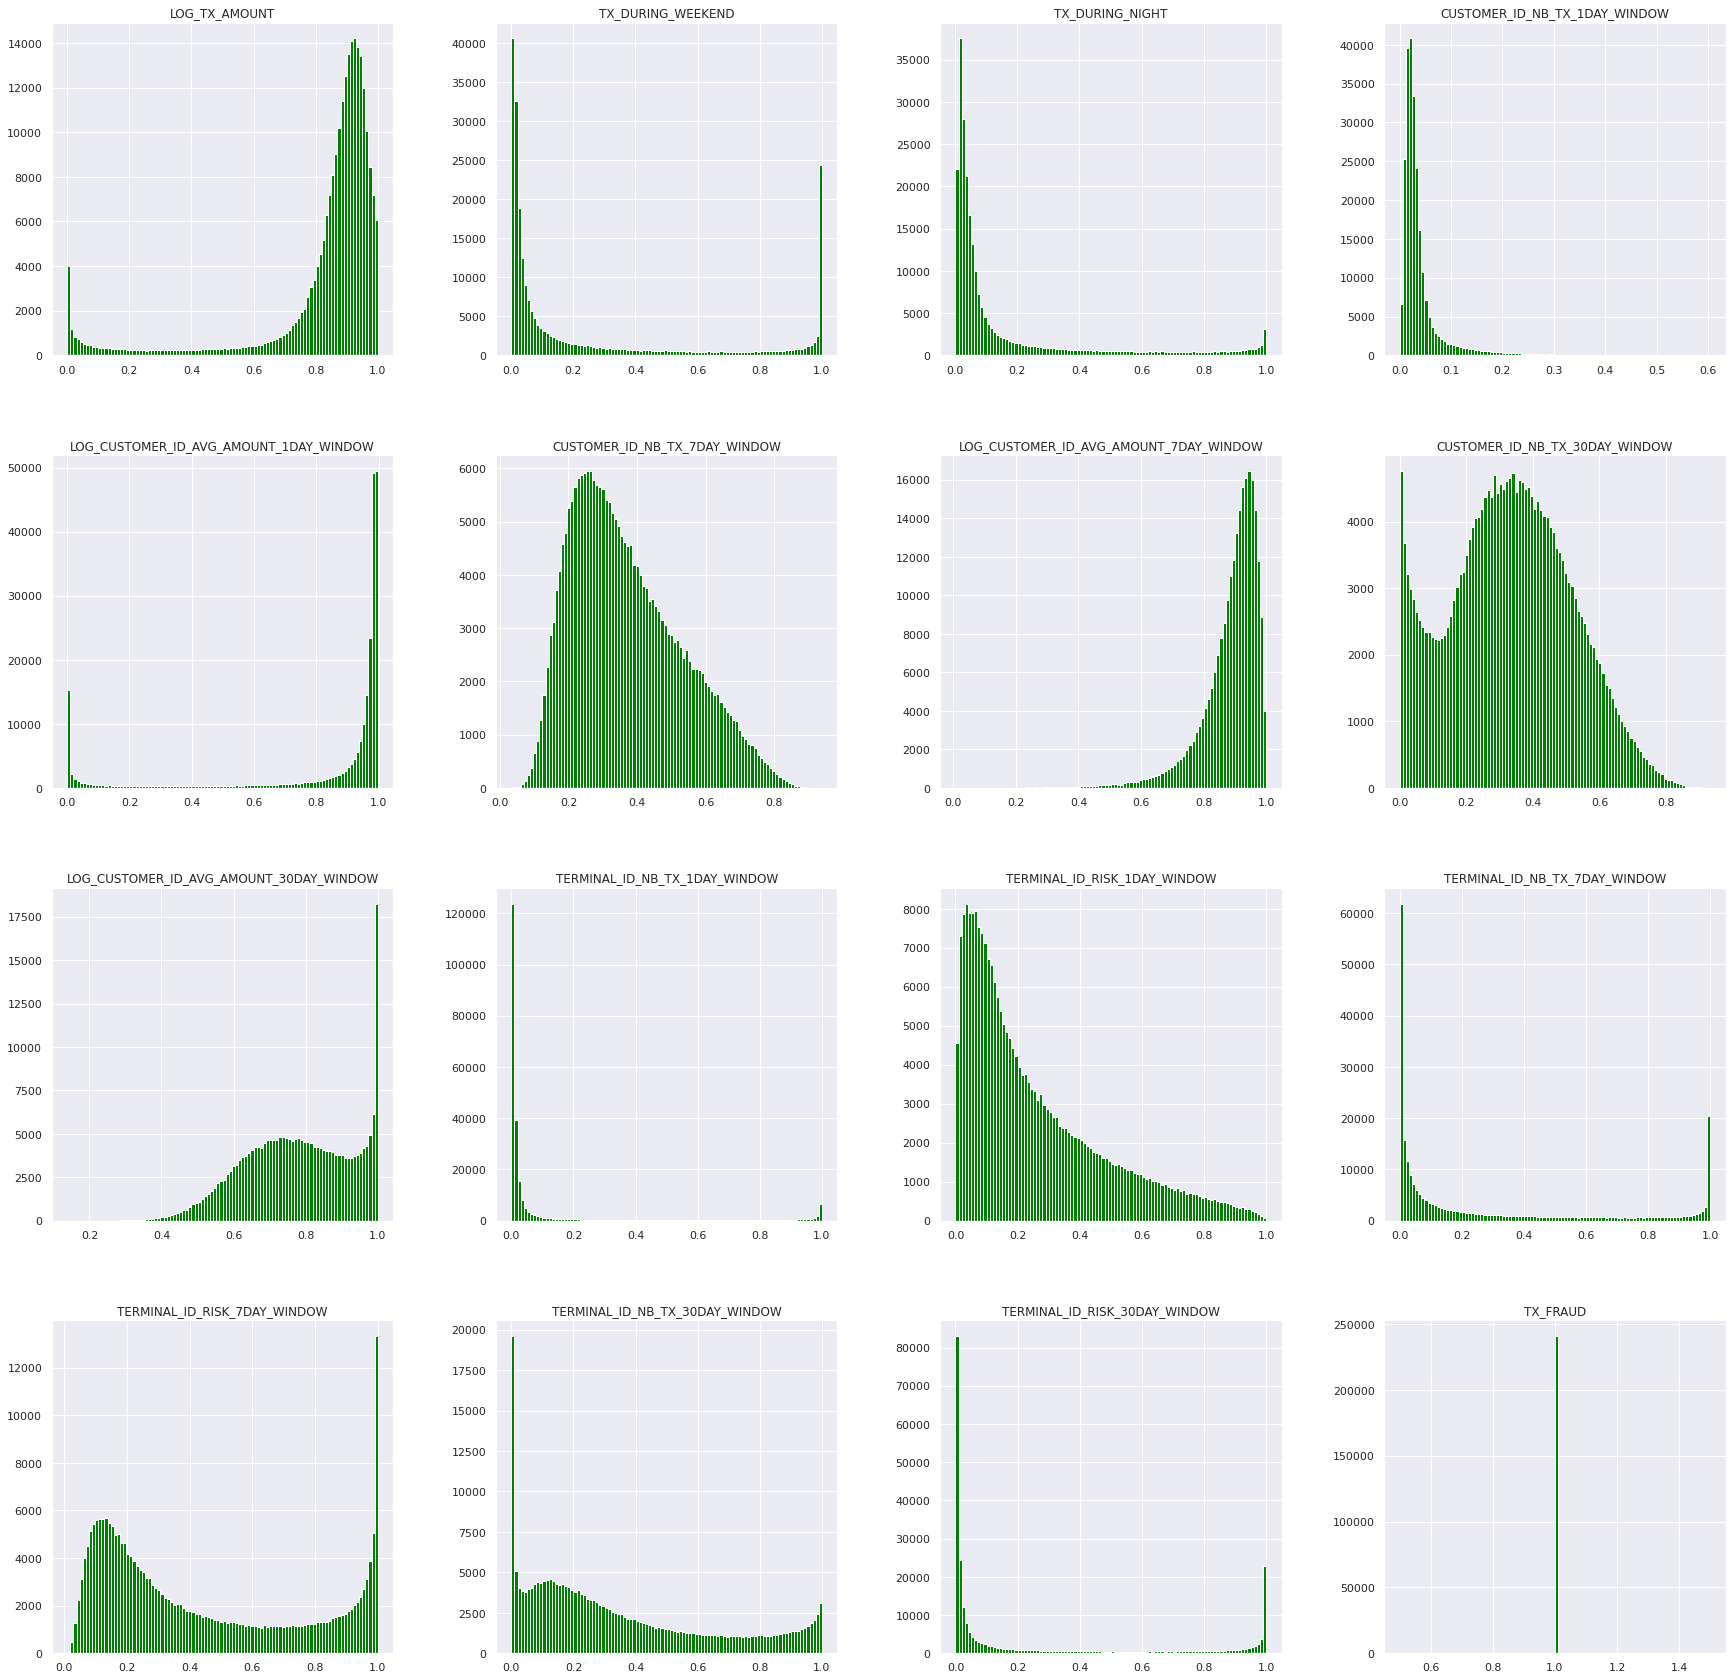

In [53]:
%matplotlib inline  
sns.set()
new_frauds_gan.hist(bins=100, figsize=(30, 30), color='green')
plt.show()

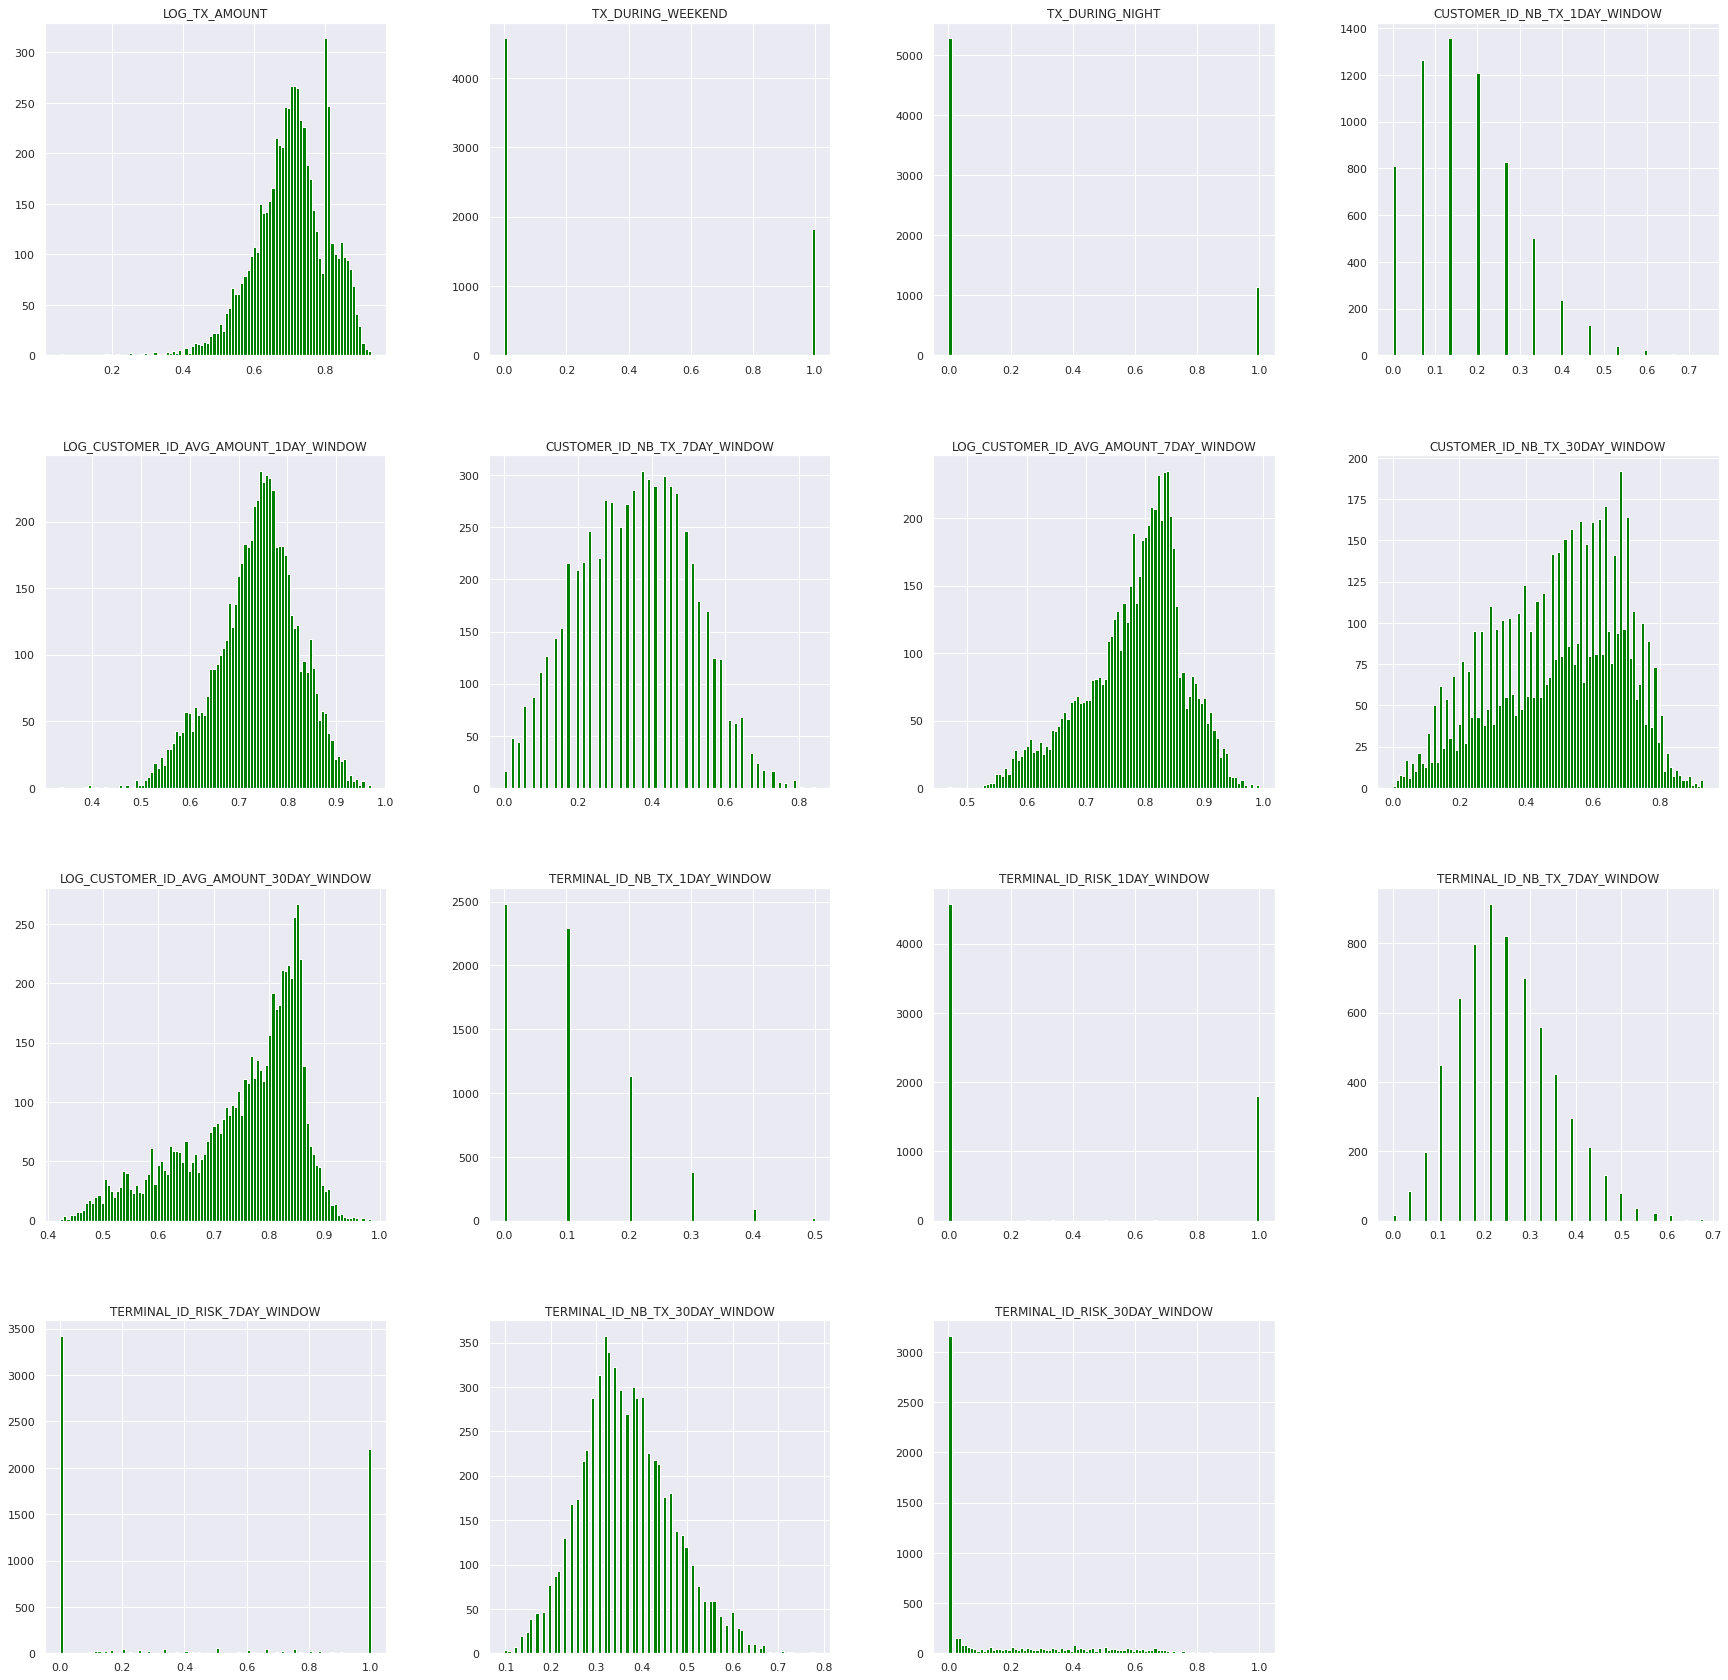

In [54]:
%matplotlib inline  
sns.set()
train_df[input_features][train_df.TX_FRAUD==1].hist(bins=100, figsize=(30, 30), color='green')
plt.show()

We observe that the total  number of transactions and the values of the generated transactions correspond with what we expect from the GAN oversampling.

Indeed, here we can see how the distribution of classes correspond to 50%. Later we will change this value to understand how this will impact our model performance

## 5.2.3 Classifiers with GAN without Cross Validation

We first start with a default Logistic regression to understand whether everything seems to work properly

In [55]:
def performance_assessment(predictions,original_ytest, fraud_proportion, oversampling,rounded =True):
    
    AUC_ROC = metrics.roc_auc_score(original_ytest, predictions)
    precision = metrics.precision_score(original_ytest, predictions)
    recall = metrics.recall_score(original_ytest, predictions)
    f1_score = metrics.f1_score(original_ytest, predictions)
    
    performances = pd.DataFrame([[AUC_ROC, precision, recall,f1_score]], 
                           columns=['AUC ROC',' Precision',' Recall', 'f1_score'])
    
    if rounded:
        performances = performances.round(3)
    performances.index=[ fraud_proportion + oversampling]
    return performances
def performance_assessment_model_collection_gan(fitted_models_and_predictions_dictionary, 
                                            test, 
                                            type_set='test'):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions, original_ytest)
        performances_model.index=[classifier_name + '_gan']
        
        performances=performances.append(performances_model)
        
    return performances



In [ ]:
from xgboost import XGBClassifier
dataset_name =  'new_balanced_dataset_gan' + str(alpha)
X_train_gan = np.array(balanced_datasets_gan[dataset_name].drop('TX_FRAUD', axis = 1))
y_train_gan = np.array(balanced_datasets_gan[dataset_name]['TX_FRAUD'])  
xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
xgb_clf.fit(X_train_gan, y_train_gan)
predictions_test = xgb_clf.predict(original_Xtest)
performance_gan_only1 = performance_assessment(predictions_test,original_ytest, str(alpha), '_gan')
performance_gan_only1

,AUC ROC,Precision,Recall,f1_score
0.2_gan,0.813,0.943,0.626,0.752


In [ ]:
from imblearn.over_sampling import SMOTE
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio=alpha/(1-alpha), random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
xgb_clf.fit(Xsm_train, ysm_train)
predictions_test = xgb_clf.predict(original_Xtest)
performance_smote_only1 = performance_assessment(predictions_test,original_ytest, str(alpha), '_smote')
performance_smote_only1

,AUC ROC,Precision,Recall,f1_score
0.2_smote,0.823,0.825,0.648,0.726


In [56]:
from xgboost import XGBClassifier
#from XGBoost import XGBClassifier
performance_gan = pd.DataFrame()
for alpha in proportion:
    dataset_name =  'new_balanced_dataset_gan' + str(alpha)
    X_train_gan = np.array(balanced_datasets_gan[dataset_name].drop('TX_FRAUD', axis = 1))
    y_train_gan = np.array(balanced_datasets_gan[dataset_name]['TX_FRAUD'])  
    xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
    xgb_clf.fit(X_train_gan, y_train_gan)
    predictions_test = xgb_clf.predict(original_Xtest)
    performance_gan = performance_gan.append(performance_assessment(predictions_test,original_ytest, str(alpha), '_gan'))
    print('here')
performance_gan

here
here
here
here
here
here
here


,AUC ROC,Precision,Recall,f1_score
0.02_gan,0.815,0.930,0.630,0.751
0.05_gan,0.813,0.934,0.627,0.750
0.1_gan,0.815,0.910,0.630,0.745
0.2_gan,0.810,0.941,0.620,0.748
0.3_gan,0.808,0.932,0.616,0.742
0.4_gan,0.810,0.933,0.619,0.745
0.5_gan,0.808,0.933,0.617,0.743


In [61]:
performance_smote_nosampling = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/performance tables/performance_smote_nosampling.csv',index_col = 'Unnamed: 0')

In [ ]:
from imblearn.over_sampling import SMOTE
performance_smote = pd.DataFrame()
# SMOTE Technique (OverSampling) After splitting and Cross Validating
for alpha in proportion:
    sm = SMOTE(ratio=alpha/(1-alpha), random_state=42)
    Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
    xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
    xgb_clf.fit(Xsm_train, ysm_train)
    predictions_test = xgb_clf.predict(original_Xtest)
    performance_smote = performance_smote.append(performance_assessment(predictions_test,original_ytest, str(alpha), '_smote'))
    print('here')
performance_smote

here
here
here
here
here
here
here


,AUC ROC,Precision,Recall,f1_score
0.02_smote,0.822,0.919,0.645,0.758
0.05_smote,0.821,0.905,0.641,0.751
0.1_smote,0.821,0.874,0.642,0.741
0.2_smote,0.823,0.825,0.648,0.726
0.3_smote,0.829,0.797,0.658,0.721
0.4_smote,0.827,0.740,0.656,0.696
0.5_smote,0.833,0.715,0.667,0.690


In [62]:
performance_total = performance_gan.append(performance_smote_nosampling)
performance_total

,AUC ROC,Precision,Recall,f1_score
0.02_gan,0.815,0.930,0.630,0.751
0.05_gan,0.813,0.934,0.627,0.750
0.1_gan,0.815,0.910,0.630,0.745
0.2_gan,0.810,0.941,0.620,0.748
0.3_gan,0.808,0.932,0.616,0.742
0.4_gan,0.810,0.933,0.619,0.745
0.5_gan,0.808,0.933,0.617,0.743
0.02_smote,0.821,0.920,0.641,0.756
0.05_smote,0.822,0.905,0.645,0.753
0.1_smote,0.824,0.868,0.648,0.742


In [63]:
xgb_clf= XGBClassifier(eta = 0.3,max_depth = 4 )
xgb_clf.fit(original_Xtrain, original_ytrain)
predictions_test_nosampling = xgb_clf.predict(original_Xtest)
performance_nosampling = performance_assessment(predictions_test_nosampling,original_ytest, 'original', 'none')

In [64]:
performance_total = performance_total.append(performance_nosampling)
performance_total

,AUC ROC,Precision,Recall,f1_score
0.02_gan,0.815,0.930,0.630,0.751
0.05_gan,0.813,0.934,0.627,0.750
0.1_gan,0.815,0.910,0.630,0.745
0.2_gan,0.810,0.941,0.620,0.748
0.3_gan,0.808,0.932,0.616,0.742
0.4_gan,0.810,0.933,0.619,0.745
0.5_gan,0.808,0.933,0.617,0.743
0.02_smote,0.821,0.920,0.641,0.756
0.05_smote,0.822,0.905,0.645,0.753
0.1_smote,0.824,0.868,0.648,0.742


In [65]:
performance_total.to_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/performance tables/table_pulito.csv')

In [66]:
for alpha in proportion:
    dataset_name =  'new_balanced_dataset_gan' + str(alpha) 
    path = '/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/gan datasets/versione pulit/' + dataset_name + '.csv'
    balanced_datasets_gan[dataset_name].to_csv(path)

In [ ]:
#Gradient Boosting
from sklearn.model_selection import GridSearchCV
xgboost_params = {'max_depth': [4,6,8,10],'eta': [0.1,0.2,0.3]}
X_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2'].drop('TX_FRAUD', axis = 1))
y_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2']['TX_FRAUD'])
grid_xgboost = GridSearchCV(XGBClassifier(), xgboost_params,cv = 3,  scoring = ['f1','recall','roc_auc','precision'], refit = 'roc_auc' )
grid_xgboost.fit(X_train_gan, y_train_gan)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'eta': [0.1, 0.2, 0.3], 'max_depth': [4, 6, 8, 10]},
             pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score=False,
             scori

In [ ]:
grid_xgboost_df = pd.DataFrame(grid_xgboost.cv_results_)
grid_xgboost_df.to_csv('/content/drive/MyDrive/Colab Notebooks/tesi/Versione agosto/CHAPTER 5: APPLICATION ON A SIMULATED DATASET/gan datasets/with sigmoid/grid classifier/grid_xgboost.csv')

In [67]:
from xgboost import XGBClassifier
X_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2'].drop('TX_FRAUD', axis = 1))
y_train_gan = np.array(balanced_datasets_gan['new_balanced_dataset_gan0.2']['TX_FRAUD'])  
xgb_clf= XGBClassifier(eta = 0.2,max_depth = 4 )
xgb_clf.fit(X_train_gan, y_train_gan)
predictions_test_gan = xgb_clf.predict(original_Xtest)
performance_gan_final = performance_assessment(predictions_test_gan,original_ytest, str(0.2), '_gan')
performance_gan_final

,AUC ROC,Precision,Recall,f1_score
0.2_gan,0.81,0.941,0.62,0.748


In [68]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio=0.2/0.8, random_state=42)
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
xgb_clf= XGBClassifier(eta = 0.2,max_depth = 4 )
xgb_clf.fit(Xsm_train, ysm_train)
predictions_test_smote = xgb_clf.predict(original_Xtest)
performance_smote_final = performance_assessment(predictions_test_smote,original_ytest, str(0.2), '_smote')
performance_smote_final

,AUC ROC,Precision,Recall,f1_score
0.2_smote,0.821,0.808,0.644,0.717


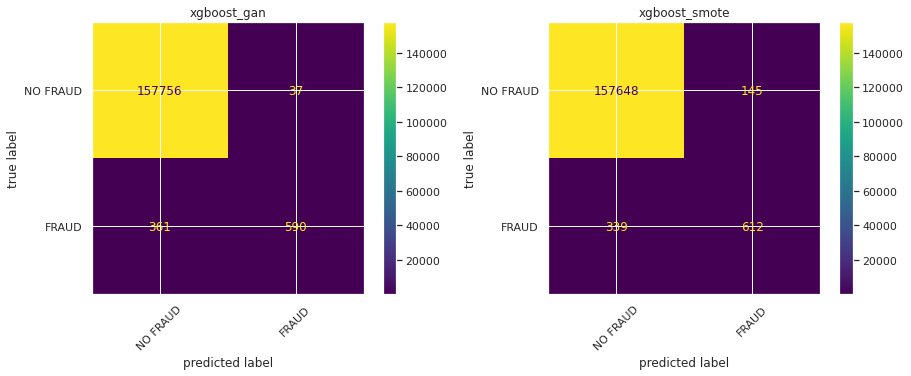

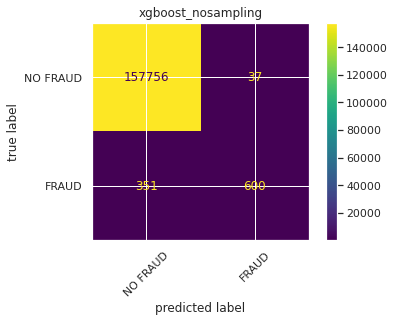

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ['NO FRAUD', 'FRAUD']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

cf_matrix = confusion_matrix(original_ytest, predictions_test_gan)
disp = ConfusionMatrixDisplay(cf_matrix,display_labels=labels)
disp.plot(xticks_rotation=45, ax=axes[0], values_format = 'g' )
disp.ax_.set_title('xgboost' + '_gan')
disp.ax_.set_xlabel('predicted label')
disp.ax_.set_ylabel('true label')


cf_matrix = confusion_matrix(original_ytest, predictions_test_smote)
disp = ConfusionMatrixDisplay(cf_matrix,display_labels=labels)
disp.plot(xticks_rotation=45, ax=axes[1], values_format = 'g' )
disp.ax_.set_title('xgboost' + '_smote')
disp.ax_.set_xlabel('predicted label')
disp.ax_.set_ylabel('true label')
plt.show()

cf_matrix = confusion_matrix(original_ytest, predictions_test_nosampling)
disp = ConfusionMatrixDisplay(cf_matrix,display_labels=labels)
disp.plot(xticks_rotation=45, values_format = 'g' )
disp.ax_.set_title('xgboost' + '_nosampling')
disp.ax_.set_xlabel('predicted label')
disp.ax_.set_ylabel('true label')
plt.show()